In [10]:
from tqdm import tqdm
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import string
from textblob import TextBlob
import preprocessor as p
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from empath import Empath


In [2]:
df = pd.read_csv('users/verified_features_2k.csv')

In [3]:
# dfs = pd.read_csv('users/verified_features.csv')

In [4]:
# dfs

In [5]:
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.MENTION, p.OPT.SMILEY, p.OPT.NUMBER)

In [6]:
df.head()

,uid,name,friends_count,followers_count,listed_count,statuses_count,pff,pfr,gcf,gcr,description,tweets,total_fake,total_real,net_trust,total_news,fake_prob,net_trust_norm,fake
0,1172796973,PTorresTV,548,1117,25,12136,0,0,23,2851,"I cover ET, lifestyle, music, sports, and more...",Chris Pratt Files for Divorce From Anna Faris ...,23,2851,2828,2874,0.008003,0.983994,0
1,1070586199,EOnlineUK,353,102733,316,60989,0,0,23,564,The official E! account for the UK & IRELAND. ...,Hours after Josh Duhamel and Fergie announced ...,23,564,541,587,0.039182,0.921635,0
2,25589776,people,1751,7565880,33588,267090,7,4,271,264,https://t.co/4HzJYZw0O4 is the No. 1 site for ...,Barbara Bush Says Grandfather George H.W. Aske...,278,268,-10,546,0.509158,-0.018315,1
3,1367531,FoxNews,398,18416786,65345,418052,8,356,17,22,"Follow America's #1 cable news network, delive...",Port Authority bombing suspect wrote on Facebo...,25,378,353,403,0.062035,0.875931,0
4,20012204,usweekly,1177,2181224,11975,188328,0,0,203,181,Your trusted source for the latest celebrity n...,PICS: Every time Justin Theroux gushed over Je...,203,181,-22,384,0.528646,-0.057292,1


In [7]:
des = list(df['description'])

In [8]:
# Happy Emoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])
 
# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

emoticons = emoticons_happy.union(emoticons_sad)

In [11]:
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

stop_words = set(stopwords.words('english'))

def clean_tweets(tweet):
    word_tokens = word_tokenize(tweet)
    
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
    tweet = emoji_pattern.sub(r'', tweet)
    
    filtered_tweet = []
    
    for w in word_tokens:
        #check tokens against stop words , emoticons and punctuations
        if w not in stop_words and w not in emoticons and w not in string.punctuation:
            filtered_tweet.append(w)
    
    tweet = ' '.join(filtered_tweet).lower()
    text = ''.join([i if ord(i) < 128 else ' ' for i in tweet])
    
    return " ".join(text.split())

In [12]:
clean_desc = []

for d in des:
    d = str(d)
    d = d.replace("\'s", " ")
    d = d.replace("`", " ")
    d = d.replace("\'", " ")
    d = d.replace("#", "").replace("_", " ")
    d = p.clean(d)
    d = clean_tweets(d)
    clean_desc.append(d)

In [13]:
print('Before: ',des[0])
print()
print('After: ', clean_desc[0])

Before:  I cover ET, lifestyle, music, sports, and more for @TelemundoAZ #AccesoTotalAZ. Earned me 4 EMMY® awards and counting. 💯%🇵🇷🦁😉My work: https://t.co/29K8QsYNs8

After:  i cover et lifestyle music sports accesototalaz earned emmy awards counting my work


In [14]:
df['description'] = clean_desc

In [15]:
df.head()

,uid,name,friends_count,followers_count,listed_count,statuses_count,pff,pfr,gcf,gcr,description,tweets,total_fake,total_real,net_trust,total_news,fake_prob,net_trust_norm,fake
0,1172796973,PTorresTV,548,1117,25,12136,0,0,23,2851,i cover et lifestyle music sports accesototala...,Chris Pratt Files for Divorce From Anna Faris ...,23,2851,2828,2874,0.008003,0.983994,0
1,1070586199,EOnlineUK,353,102733,316,60989,0,0,23,564,the official e account uk ireland get eredcarp...,Hours after Josh Duhamel and Fergie announced ...,23,564,541,587,0.039182,0.921635,0
2,25589776,people,1751,7565880,33588,267090,7,4,271,264,no site celebrity news and subscribe snapchat ...,Barbara Bush Says Grandfather George H.W. Aske...,278,268,-10,546,0.509158,-0.018315,1
3,1367531,FoxNews,398,18416786,65345,418052,8,356,17,22,follow america cable news network delivering b...,Port Authority bombing suspect wrote on Facebo...,25,378,353,403,0.062035,0.875931,0
4,20012204,usweekly,1177,2181224,11975,188328,0,0,203,181,your trusted source latest celebrity news phot...,PICS: Every time Justin Theroux gushed over Je...,203,181,-22,384,0.528646,-0.057292,1


In [16]:
tweets = list(df['tweets'])

In [17]:
clean_tweet = []

for tweet in tweets:
    tw = tweet.split('^')
    clean_tw = []

    for d in tw:
        d = str(d)
        d = d.replace("\'s", " ")
        d = d.replace("`", "");
        d = d.replace("\"", "")
        d = d.replace("-", " ")
        d = d.replace("#", "").replace("_", " ")
        d = p.clean(d)
        d = clean_tweets(d)
        clean_tw.append(d)
#         print(clean_tw)
    clean_tweet.append("^".join(clean_tw))

In [18]:
print('Before: ',tweets[0].split("^")[2])
print()
print('After: ', clean_tweet[0].split("^")[2])

Before:  Josh Duhamel and Fergie's Relationship in the "Best Place" After Split https://t.co/yqfAwClpkV https://t.co/3sKNiULVNM

After:  josh duhamel fergie relationship best place after split


In [19]:
df['tweets'] = clean_tweet

In [20]:
# df.head()

In [21]:
df.to_csv("users/verified_features_clean_2k.csv", index = False)

In [22]:
# df = pd.read_csv('users/verified_features_clean.csv')

In [23]:
df.head()

,uid,name,friends_count,followers_count,listed_count,statuses_count,pff,pfr,gcf,gcr,description,tweets,total_fake,total_real,net_trust,total_news,fake_prob,net_trust_norm,fake
0,1172796973,PTorresTV,548,1117,25,12136,0,0,23,2851,i cover et lifestyle music sports accesototala...,chris pratt files divorce from anna faris^the ...,23,2851,2828,2874,0.008003,0.983994,0
1,1070586199,EOnlineUK,353,102733,316,60989,0,0,23,564,the official e account uk ireland get eredcarp...,hours josh duhamel fergie announced split josh...,23,564,541,587,0.039182,0.921635,0
2,25589776,people,1751,7565880,33588,267090,7,4,271,264,no site celebrity news and subscribe snapchat ...,barbara bush says grandfather george h.w asked...,278,268,-10,546,0.509158,-0.018315,1
3,1367531,FoxNews,398,18416786,65345,418052,8,356,17,22,follow america cable news network delivering b...,port authority bombing suspect wrote facebook ...,25,378,353,403,0.062035,0.875931,0
4,20012204,usweekly,1177,2181224,11975,188328,0,0,203,181,your trusted source latest celebrity news phot...,pics every time justin theroux gushed jennifer...,203,181,-22,384,0.528646,-0.057292,1


In [24]:
desc = list(df['description'])

In [25]:
desc_sub = []
desc_polar = []

for d in tqdm(desc):
    d = str(d)
    text = TextBlob(d)
    
    desc_sub.append(text.sentiment.subjectivity)
    desc_polar.append(text.sentiment.polarity)    

100%|██████████| 2081/2081 [00:01<00:00, 1300.67it/s]


In [26]:
df['desc_subjectivity'] = desc_sub 
df['desc_polarity'] = desc_polar

In [27]:
df.head(2)

,uid,name,friends_count,followers_count,listed_count,statuses_count,pff,pfr,gcf,gcr,...,tweets,total_fake,total_real,net_trust,total_news,fake_prob,net_trust_norm,fake,desc_subjectivity,desc_polarity
0,1172796973,PTorresTV,548,1117,25,12136,0,0,23,2851,...,chris pratt files divorce from anna faris^the ...,23,2851,2828,2874,0.008003,0.983994,0,0.0,0.0
1,1070586199,EOnlineUK,353,102733,316,60989,0,0,23,564,...,hours josh duhamel fergie announced split josh...,23,564,541,587,0.039182,0.921635,0,0.0,0.0


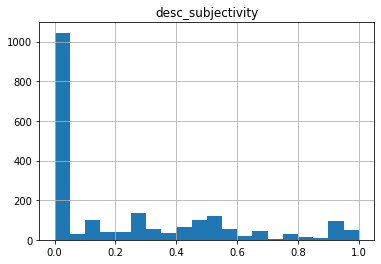

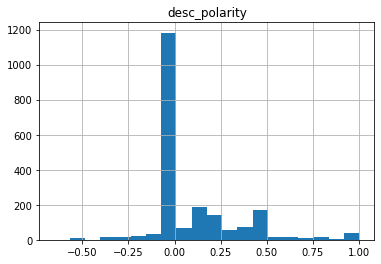

In [28]:
df.hist(column='desc_subjectivity', bins=20)
df.hist(column='desc_polarity', bins=20)

plt.show()

In [29]:
tweets = list(df['tweets'])

tweets_sub = []
tweets_polar = []

for tweet in tqdm(tweets):
    tw = tweet.split("^")
    num = len(tw)
    
    sub_arr = []
    polar_arr = []
    
    for d in tw:

        d = str(d)
        text = TextBlob(d)

        sub_arr.append(text.sentiment.subjectivity)
        polar_arr.append(text.sentiment.polarity)    

    sub = sum(sub_arr)/num
    polar = sum(polar_arr)/num    
    
    tweets_sub.append(sub)
    tweets_polar.append(polar)

100%|██████████| 2081/2081 [00:23<00:00, 89.73it/s] 


In [30]:
df['tweets_subjectivity'] = tweets_sub 
df['tweets_polarity'] = tweets_polar

In [31]:
df.head(2)

,uid,name,friends_count,followers_count,listed_count,statuses_count,pff,pfr,gcf,gcr,...,total_real,net_trust,total_news,fake_prob,net_trust_norm,fake,desc_subjectivity,desc_polarity,tweets_subjectivity,tweets_polarity
0,1172796973,PTorresTV,548,1117,25,12136,0,0,23,2851,...,2851,2828,2874,0.008003,0.983994,0,0.0,0.0,0.312530,0.093912
1,1070586199,EOnlineUK,353,102733,316,60989,0,0,23,564,...,564,541,587,0.039182,0.921635,0,0.0,0.0,0.301738,0.076067


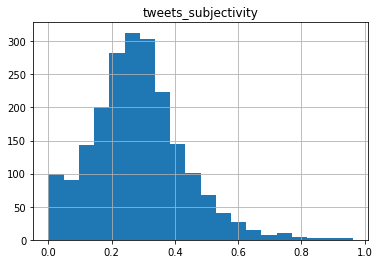

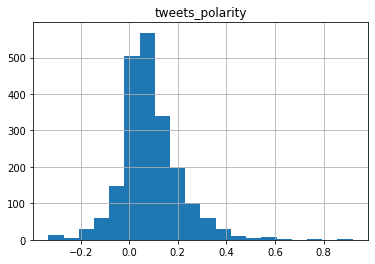

In [32]:
df.hist(column='tweets_subjectivity', bins=20)
df.hist(column='tweets_polarity', bins=20)

plt.show()

In [33]:
lexicon = Empath()

In [34]:
ex = lexicon.analyze(desc[0], normalize=True)

In [35]:
it = list(ex.items())

header = [x for (x,y) in it]

In [36]:
def column_sum(lst):   
    return [sum(i) for i in zip(*lst)] 

In [37]:
ans = []

for tweet in tqdm(tweets):
    tw = tweet.split("^")
    num = len(tw)
    
    arr = []
    
    for d in tw:

        d = str(d)
        if d == "":
            continue
        it = list(lexicon.analyze(d, normalize=True).items())
        emp = [y for (x,y) in it]
        arr.append(emp)
    
    col_sum = column_sum(arr)
    ans.append([x/num for x in col_sum])

100%|██████████| 2081/2081 [05:36<00:00,  6.19it/s]


In [38]:
# tweets[585].split("^")

In [39]:
len(ans)

2081

In [40]:
len(ans[0])

194

In [41]:
new_head = []

for head in header:
    new_head.append(head + "_empath")

In [42]:
df_empath = pd.DataFrame(ans, columns = new_head) 

In [43]:
df_empath

,help_empath,office_empath,dance_empath,money_empath,wedding_empath,domestic_work_empath,sleep_empath,medical_emergency_empath,cold_empath,hate_empath,...,weapon_empath,children_empath,monster_empath,ocean_empath,giving_empath,contentment_empath,writing_empath,rural_empath,positive_emotion_empath,musical_empath
0,0.002503,0.001585,0.009541,0.001987,0.022792,0.006143,0.001275,0.004969,0.001119,0.001484,...,0.002391,0.021099,0.001657,0.001920,0.003702,0.000585,0.002335,0.002460,0.007839,0.011049
1,0.002964,0.001607,0.009846,0.002328,0.026361,0.004240,0.001340,0.005193,0.000997,0.002268,...,0.002308,0.021205,0.002619,0.002023,0.005247,0.000557,0.002802,0.002584,0.009525,0.013514
2,0.003162,0.002072,0.005707,0.001691,0.036405,0.007570,0.002665,0.009108,0.001742,0.002916,...,0.002769,0.032744,0.000474,0.001301,0.002765,0.000771,0.004536,0.005398,0.009638,0.008561
3,0.002774,0.046930,0.018994,0.006579,0.009791,0.008204,0.011199,0.002914,0.001927,0.001500,...,0.002891,0.004289,0.001988,0.001589,0.001920,0.000191,0.003285,0.004726,0.002932,0.018821
4,0.001367,0.002343,0.003676,0.000217,0.045730,0.003368,0.000237,0.009023,0.000875,0.002118,...,0.000750,0.035524,0.000372,0.002707,0.002477,0.000550,0.005693,0.001944,0.007702,0.008623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2076,0.000000,0.022222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.022222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2077,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.150000,0.000000,0.000000,0.083333
2078,0.000000,0.000000,0.000000,0.000000,0.025641,0.027778,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.051282,0.000000,0.000000,0.000000,0.000000,0.025641,0.000000,0.000000,0.000000
2079,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.055556


In [44]:
cols = ['pff', 'pfr', 'gcf', 'gcr', 'description', 'tweets', 'total_fake',
        'total_real', 'net_trust', 'total_news', 'fake_prob', 'net_trust_norm']

df.drop(cols, axis=1, inplace=True)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2081 entries, 0 to 2080
Data columns (total 11 columns):
uid                    2081 non-null int64
name                   2081 non-null object
friends_count          2081 non-null int64
followers_count        2081 non-null int64
listed_count           2081 non-null int64
statuses_count         2081 non-null int64
fake                   2081 non-null int64
desc_subjectivity      2081 non-null float64
desc_polarity          2081 non-null float64
tweets_subjectivity    2081 non-null float64
tweets_polarity        2081 non-null float64
dtypes: float64(4), int64(6), object(1)
memory usage: 179.0+ KB


In [46]:
df_features = pd.concat(
    [
        df, df_empath
    ], axis=1
)

In [47]:
df_features.head(10)

,uid,name,friends_count,followers_count,listed_count,statuses_count,fake,desc_subjectivity,desc_polarity,tweets_subjectivity,...,weapon_empath,children_empath,monster_empath,ocean_empath,giving_empath,contentment_empath,writing_empath,rural_empath,positive_emotion_empath,musical_empath
0,1172796973,PTorresTV,548,1117,25,12136,0,0.000000,0.000,0.312530,...,0.002391,0.021099,0.001657,0.001920,0.003702,0.000585,0.002335,0.002460,0.007839,0.011049
1,1070586199,EOnlineUK,353,102733,316,60989,0,0.000000,0.000,0.301738,...,0.002308,0.021205,0.002619,0.002023,0.005247,0.000557,0.002802,0.002584,0.009525,0.013514
2,25589776,people,1751,7565880,33588,267090,1,0.000000,0.000,0.324708,...,0.002769,0.032744,0.000474,0.001301,0.002765,0.000771,0.004536,0.005398,0.009638,0.008561
3,1367531,FoxNews,398,18416786,65345,418052,0,0.000000,0.000,0.214538,...,0.002891,0.004289,0.001988,0.001589,0.001920,0.000191,0.003285,0.004726,0.002932,0.018821
4,20012204,usweekly,1177,2181224,11975,188328,1,0.900000,0.500,0.264836,...,0.000750,0.035524,0.000372,0.002707,0.002477,0.000550,0.005693,0.001944,0.007702,0.008623
5,21246105,HollywoodLife,4407,335776,2163,186740,1,0.000000,0.000,0.303081,...,0.002784,0.033494,0.000262,0.000654,0.000238,0.000742,0.000187,0.003281,0.013914,0.003584
6,16331010,TMZ,910,5042080,21882,269730,0,0.158333,0.125,0.336566,...,0.005949,0.022000,0.000419,0.000000,0.003441,0.000000,0.002156,0.006417,0.004358,0.006154
7,111556701,DailyMailCeleb,979,303051,2456,147432,1,0.450000,0.250,0.327580,...,0.002308,0.036154,0.000232,0.002746,0.002917,0.000464,0.000938,0.005277,0.006110,0.004544
8,14934818,InStyle,2438,4421036,20536,223111,1,0.000000,0.000,0.413821,...,0.001658,0.060621,0.000000,0.001741,0.002935,0.000557,0.001105,0.000557,0.035676,0.002320
9,45564482,NYMag,867,1798360,14118,160387,1,0.100000,0.100,0.371072,...,0.001597,0.013357,0.001866,0.003679,0.006778,0.002236,0.005713,0.001679,0.006879,0.011637


In [48]:
df_features.to_csv('users/verified_features_all_300k.csv', index=False)

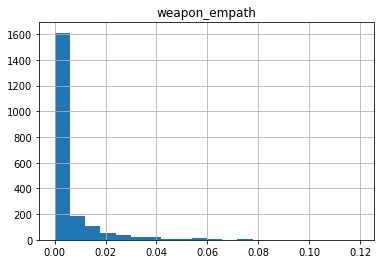

In [49]:
df_features.hist(column='weapon_empath', bins=20)


plt.show()

In [50]:

# df_features.hist(column='friends_count', bins=20)
# df_features.hist(column='followers_count', bins=20)
# df_features.hist(column='listed_count', bins=30)
# df_features.hist(column='statuses_count', bins=30)

# plt.show()

In [51]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2081 entries, 0 to 2080
Columns: 205 entries, uid to musical_empath
dtypes: float64(198), int64(6), object(1)
memory usage: 3.3+ MB
